# Fine-tune BERT with GoEmotions Dataset

## Preparation

In [3]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    n_gpu = torch.cuda.device_count()
    print('%d GPU(s):' % n_gpu)
    print([torch.cuda.get_device_name(i) for i in range(n_gpu)])
    print('available.')
else:
    print('No GPU available, using the CPU.')
    device = torch.device("cpu")
!nvidia-smi

1 GPU(s):
['NVIDIA GeForce GTX 1660 SUPER']
available.
Fri Feb  3 21:36:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   31C    P8    12W / 125W |    973MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

### Install and Import

In [5]:
!pip install -q torch
!pip install -q evaluate
!pip install -q matplotlib
!pip install -q transformers
!pip install -q huggingface_hub
!pip install -q transformers datasets



import os
import torch
import random
import evaluate
import datasets
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from huggingface_hub import notebook_login
from datasets import list_datasets, load_dataset
from transformers import (
    AdamW,
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    EvalPrediction,
    TrainingArguments,
    Trainer,
)

In [9]:
#@title Initialize { display-mode: "both" }

#@markdown #####**Model Config:**

model_name = "bert-base-uncased" #@param {type:"string"}
dataset_name = "go_emotions" #@param {type:"string"}
num_train_epochs = 10 #@param {type:"number"}
learning_rate = 5e-5 #@param {type:"number"}
batch_size = 16 #@param {type:"number"}
tokenizer_max_len = 200 #@param {type:"number"}
num_labels = 28 #@param {type:"integer"}
working_directory = "C:/Users/m1500/Documents/Notebook/" #@param {type:"string"}
pt_save_directory = "C:/Users/m1500/Documents/Notebook/bert-base-goemotions/" #@param {type:"string"}
model_save_directory = "C:/Users/m1500/Documents/Notebook/pretrained_model/bert-base-goemotions/" #@param {type:"string"}

training_args = TrainingArguments(
    output_dir=pt_save_directory,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model = "accuracy",
    remove_unused_columns=True,
)

os.chdir(working_directory)

## Preprocess

### Define Labels

In [62]:
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral',]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)} 

### Load Dataset

In [40]:
dataset = load_dataset(dataset_name)

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))
show_random_elements(dataset["train"])

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (C:/Users/m1500/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)


  0%|          | 0/3 [00:00<?, ?it/s]

,text,labels,id
0,Every instagram page posts this lol,[1],eeokhn8
1,"All the things you've been thinking about, fangirls, make me sad.",[25],ef7pww4
2,Get well soon good boye,[5],ee4k88u
3,For some reason I read that in [NAME]' voice lmao,[27],ed34yr4
4,You win one internet!,[0],edottp2
5,"What is it that we don't know yet about the Rebellion, if you don't mind me asking?",[7],ee3w9xi
6,could've directed them to the employees. it's not hard especially if they're 3 inches from you,[27],eed8gqy
7,"It is incredibly dangerous which is why there are professionals for this, also these professionals use a saber and not a kitchen knife",[22],eem4t9e
8,I see lotsa [NAME] I’m proud,"[0, 21]",ee65jjp
9,This is a thing of beauty,[0],ed63qhm


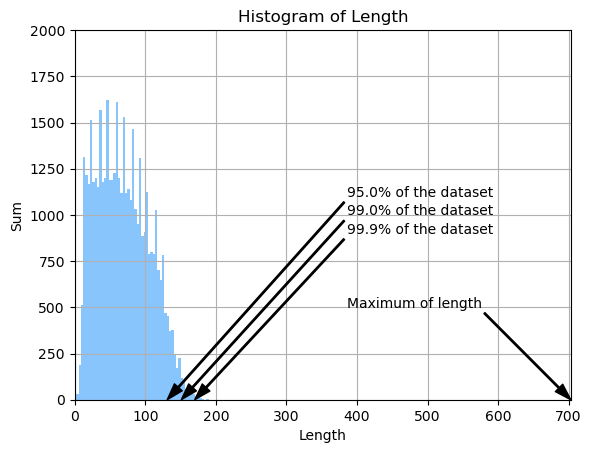

In [12]:
length_list = []
for text in dataset["train"]["text"]:
    length_list.append(len(text))
length_list.sort(reverse = False)
length_max = max(length_list)
sum_95 = length_list[int(0.95 * len(length_list))]
sum_99 = length_list[int(0.99 * len(length_list))]
sum_999 = length_list[int(0.999 * len(length_list))]
length_array = np.asarray(length_list)

n, bins, patches = plt.hist(length_array, "auto", facecolor="xkcd:sky blue", alpha = 0.85)
plt.xlabel("Length")
plt.ylabel("Sum")
plt.title("Histogram of Length")
plt.annotate("95.0% of the dataset", xy=(sum_95, 0), xytext=(sum_99 + length_max / 3, 1100),
             arrowprops=dict(width=1, headwidth=7.5, facecolor="black", shrink=0),
             )
plt.annotate("99.0% of the dataset", xy=(sum_99, 0), xytext=(sum_99 + length_max / 3, 1000),
             arrowprops=dict(width=1, headwidth=7.5, facecolor="black", shrink=0),
             )
plt.annotate("99.9% of the dataset", xy=(sum_999, 0), xytext=(sum_99 + length_max / 3, 900),
             arrowprops=dict(width=1, headwidth=7.5, facecolor="black", shrink=0),
             )
plt.annotate("Maximum of length", xy=(length_max, 0), xytext=(sum_99 + length_max / 3, 500),
             arrowprops=dict(width=1, headwidth=7.5, facecolor="black", shrink=0),
             )
plt.axis([0, length_max, 0, 2000])
plt.grid(True)
plt.show()

### Tokenize

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

def tokenize_dataset(dataset):
  text = dataset["text"]
  encoding = tokenizer(dataset["text"], padding = True, max_length = tokenizer_max_len, truncation = True)
  labels_matrix = np.zeros((len(text), len(labels)))
  for idx, label_list in enumerate(dataset["labels"]):
    for id, label in enumerate(label_list):
      labels_matrix[idx, label] = 1
  encoding["label"] = labels_matrix.astype("float").tolist()
  return encoding

tokenized_dataset = dataset.map(tokenize_dataset, batched = True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

  0%|          | 0/44 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [14]:
example = tokenized_dataset["validation"][random.randint(0,len(dataset["validation"]))]
print(example.keys())
print(tokenizer.decode(example["input_ids"]))
print(example["label"])
print(example["label"].type())
[id2label[idx] for idx, label in enumerate(example["label"]) if label == 1.0]

dict_keys(['input_ids', 'attention_mask', 'label'])
[CLS] i can't help but agree with the headline at the bottom, bright side ( the youtube channel ) is annoying. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.FloatTensor


['annoyance', 'approval']

## Fine-tune

### Load Model

In [ ]:
pt_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    problem_type = "multi_label_classification",
    num_labels = num_labels,
    id2label=id2label,
    label2id=label2id
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Build Compute Metrics

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

### Build Trainer

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

trainer = Trainer(
    model=pt_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

/bert-base-goemotions/ is already a clone of https://huggingface.co/IsaacZhy/bert-base-goemotions. Make sure you pull the latest changes with `repo.git_pull()`.


### Train

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 43410
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 27140
  Number of trainable parameters = 109503772


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.083300,0.087594,0.545315,0.718877,0.424254
2,0.071900,0.086656,0.558560,0.732238,0.439919
3,0.057500,0.094265,0.573614,0.752348,0.466458
4,0.041100,0.106383,0.565540,0.757983,0.457427
5,0.030100,0.116736,0.562191,0.759060,0.451714
6,0.021700,0.127946,0.557861,0.764782,0.437523
7,0.015000,0.136702,0.566346,0.775878,0.433284
8,0.010200,0.144513,0.569532,0.779264,0.432178
9,0.007700,0.149100,0.572537,0.779497,0.436602
10,0.005700,0.153852,0.572669,0.779647,0.437523


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, id. If text, id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5426
  Batch size = 16
Saving model checkpoint to /bert-base-goemotions/checkpoint-2714
Configuration saved in /bert-base-goemotions/checkpoint-2714/config.json
Model weights saved in /bert-base-goemotions/checkpoint-2714/pytorch_model.bin
tokenizer config file saved in /bert-base-goemotions/checkpoint-2714/tokenizer_config.json
Special tokens file saved in /bert-base-goemotions/checkpoint-2714/special_tokens_map.json
tokenizer config file saved in /bert-base-goemotions/tokenizer_config.json
Special tokens file saved in /bert-base-goemotions/special_tokens_map.json
Several commits (2) will be pushed upstream.
The following columns in the evaluation set don't have a correspondin

TrainOutput(global_step=27140, training_loss=0.03509321852958457, metrics={'train_runtime': 6530.0012, 'train_samples_per_second': 66.478, 'train_steps_per_second': 4.156, 'total_flos': 2.627342741935651e+16, 'train_loss': 0.03509321852958457, 'epoch': 10.0})

### Test

In [18]:
n = random.randint(0,len(dataset["test"]))
text = tokenized_dataset["test"]["text"][n]
print(text)
labels = [id2label[idx] for idx, label in enumerate(tokenized_dataset["test"]["label"][n]) if label == 1.0]
print(labels)

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits
logits.shape

sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1

predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

Been saying horford has been overrated since he got that fat contract
['disapproval']
['neutral']


## Save

In [ ]:
pt_model.save_pretrained(model_save_directory)

Configuration saved in /content/drive/MyDrive/GraduationDesign/pretrained_model/bert-base-goemotions/config.json
Model weights saved in /content/drive/MyDrive/GraduationDesign/pretrained_model/bert-base-goemotions/pytorch_model.bin


### Save to Huggingface

In [ ]:
trainer.push_to_hub("bert-base-goemotions")
tokenizer.push_to_hub("bert-base-goemotions")

Saving model checkpoint to /bert-base-goemotions/
Configuration saved in /bert-base-goemotions/config.json
Model weights saved in /bert-base-goemotions/pytorch_model.bin
tokenizer config file saved in /bert-base-goemotions/tokenizer_config.json
Special tokens file saved in /bert-base-goemotions/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Feb03_11-04-06_76791afd488f/events.out.tfevents.1675422266.76791afd488f.1222.2: 100%|########…

remote: Scanning LFS files for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/IsaacZhy/bert-base-goemotions
   52928bd..2d5ddf5  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/IsaacZhy/bert-base-goemotions
   52928bd..2d5ddf5  main -> main

To https://huggingface.co/IsaacZhy/bert-base-goemotions
   2d5ddf5..8f1b621  main -> main

   2d5ddf5..8f1b621  main -> main

tokenizer config file saved in /tmp/tmpgpslo6fr/tokenizer_config.json
Special tokens file saved in /tmp/tmpgpslo6fr/special_tokens_map.json
Uploading the following files to IsaacZhy/bert-base-goemotions: tokenizer.json,special_tokens_map.json,vocab.txt,tokenizer_config.json


CommitInfo(commit_url='https://huggingface.co/IsaacZhy/bert-base-goemotions/commit/cbc7557badff8ef175847a6b01f1f41c91c5d714', commit_message='Upload tokenizer', commit_description='', oid='cbc7557badff8ef175847a6b01f1f41c91c5d714', pr_url=None, pr_revision=None, pr_num=None)

# Analyse Speech Context using Fine-tuned Model

## Load Data

### Define Labels of States

In [19]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
id2state = {idx:state for idx, state in enumerate(states)}
state2id = {state:idx for idx, state in enumerate(states)} 

### Load Speech Context

In [20]:
os.chdir(working_directory + "/data")
work_dir = os.getcwd()
candidates = os.listdir(work_dir)
candidates.sort()
result = []
for i in range(len(candidates)):
    result.append(np.zeros((len(states), num_labels), int))
results = dict(zip(candidates, result))

### Load Model

In [16]:
pt_model = AutoModelForSequenceClassification.from_pretrained("IsaacZhy/bert-base-goemotions", problem_type = "multi_label_classification", num_labels = num_labels, id2label=id2label, label2id=label2id)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

trainer = Trainer(
    model=pt_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Downloading:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub-0.11.1-py3.8.egg\huggingface_hub\file_download.py:127: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\m1500\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

### Process Speech Context

In [23]:
import re

sigmoid = torch.nn.Sigmoid()

for candidate in candidates:
    texts = os.listdir(work_dir + '/' + candidate)
    texts.sort()
    for text in texts:
        with open(work_dir + '/' + candidate + '/' + text, 'r', encoding = 'utf-8') as txt:
            state = text[len(candidate)+1] + text[len(candidate)+2]
            speech_text = txt.readline()
            sentences = re.split('[!?.]', speech_text)
            for sentence in sentences:
                encoding = tokenizer(sentence, return_tensors="pt")
                encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}
                outputs = trainer.model(**encoding)
                logits = outputs.logits               
                probs = sigmoid(logits.squeeze().cpu())
                predictions = np.zeros(num_labels)
                predictions[np.where(probs >= 0.5)] = 1
                results[candidate][state2id[state]] = results[candidate][state2id[state]] + predictions
print("Processing over")

Processing over


## Classification

### Classify States

In [21]:
black_states = ['AL', 'AR', 'DE', 'FL', 'GA', 'IL', 'LA', 'MD', 'MI', 'MS', 'NC', 'NY', 'SC', 'TN', 'VA']
white_states = ['AK', 'AZ', 'CA', 'CO', 'CT', 'HI', 'ID', 'IN', 'IA', 'KS', 'KY', 'ME', 'MA', 'MN', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SD', 'TX', 'UT', 'VT', 'WA', 'WV', 'WI', 'WY']

red_states = ['AL', 'AK', 'AL', 'AR', 'ID', 'KS', 'KY', 'LA', 'MO', 'MS', 'MT', 'ND', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WV', 'WY']
blue_states = ['CA', 'CO', 'CT', 'DE', 'HI', 'IN', 'MA', 'MD', 'ME', 'MN', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OR', 'RI', 'VA', 'VT', 'WA']
swing_states = ['AZ', 'FL', 'GA', 'IA', 'IN', 'MI', 'NC', 'OH', 'PA', 'WI']

democrats = ['Biden', 'Harris', 'Obama', 'Sanders']
republicans = ['Pence', 'Trump']

republicans_results = ['AL', 'AK', 'AR', 'FL', 'ID', 'IN', 'IA', 'KS', 'KY', 'LA', 'MS', 'MO', 'MT', 'NE', 'NC', 'ND', 'OH', 'OK', 'SC', 'SD', 'TN', 'TX', 'UT', 'WV', 'WY']
democrats_results = ['AZ', 'CA', 'CO', 'CT', 'DE', 'GA', 'HI', 'IL', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI']

### Classify Sentiments

In [34]:
comparison = ['approval', 'disapproval', 'confusion']
sadness = ['disappointment', 'grief', 'remorse', 'sadness']
happiness = ['amusement', 'excitement', 'joy']
desire = ['desire', 'gratitude']

ambiguous = ['confusion', 'curiosity', 'realization', 'surprise']
positive = ['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief']
negative = ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness']

## Visualization

### Build Functions

In [65]:
def count_in_classification(party, result, classification):
    count = np.zeros(num_labels)
    required_states = []
    if party == "democrats":
        if result == "win":
            if classification == "white":
                required_states = [state for state in white_states if state in democrats_results]
            elif classification == "black":
                required_states = [state for state in black_states if state in democrats_results]
            elif classification == "swing":
                required_states = [state for state in swing_states if state in democrats_results]
        elif result == "loss":
            if classification == "white":
                required_states = [state for state in white_states if state in republicans_results]
            elif classification == "black":
                required_states = [state for state in black_states if state in republicans_results]
            elif classification == "swing":
                required_states = [state for state in swing_states if state in republicans_results]
        for candidate in democrats:
            for state in required_states:
                count = count + results[candidate][state2id[state]]
    elif party == "republicans":
        if result == "win":
            if classification == "white":
                required_states = [state for state in white_states if state in republicans_results]
            elif classification == "black":
                required_states = [state for state in black_states if state in republicans_results]
            elif classification == "swing":
                required_states = [state for state in swing_states if state in republicans_results]
        elif result == "loss":
            if classification == "white":
                required_states = [state for state in white_states if state in democrats_results]
            elif classification == "black":
                required_states = [state for state in black_states if state in democrats_results]
            elif classification == "swing":
                required_states = [state for state in swing_states if state in democrats_results]
        for candidate in republicans:
            for state in required_states:
                count = count + results[candidate][state2id[state]]
    percentage = np.zeros(num_labels - 1)
    for i in range(len(count) - 1):
        percentage[i] = count[i] / (sum(count) - count[27])
    percentage = np.multiply(percentage,np.asarray([100]))
    return percentage

def count_sum(party):
    count = np.zeros(num_labels, int)
    if party == 'democrats':     
        for candidate in democrats:
            for state_id in range(len(states)):
                count = count + results[candidate][state_id]
    elif party == 'republicans':
        for candidate in republicans:
            for state_id in range(len(states)):
                count = count + results[candidate][state_id]
    percentage = np.zeros(num_labels - 1)
    for i in range(len(count) - 1):
        percentage[i] = count[i] / (sum(count) - count[27])
    percentage = np.multiply(percentage,np.asarray([100]))
    return percentage

np.set_printoptions(threshold = 10000)
for candidate in candidates:
    print(candidate)
    df = pd.DataFrame(results[candidate], index=states, columns=labels)
    display(HTML(df.to_html()))

Biden


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,11,0,1,1,20,5,2,1,2,3,11,0,0,0,0,10,0,0,0,0,4,1,3,0,1,8,0,172
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,4,0,1,0,11,2,1,0,0,0,4,0,0,0,0,8,0,2,0,0,4,3,2,0,0,1,0,77
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,8,0,0,0,94,30,18,9,4,8,37,0,0,3,6,15,0,5,3,2,36,0,9,1,7,17,4,583
FL,67,3,2,10,234,50,27,35,7,17,52,1,1,3,3,89,0,13,7,1,67,1,32,0,12,45,2,1226
GA,18,1,1,1,40,8,1,2,1,1,16,1,0,0,0,7,0,1,1,0,19,0,7,0,0,18,2,189


Harris


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,7,0,0,0,24,1,4,3,3,3,1,0,0,1,1,9,0,3,1,0,6,1,4,0,0,5,0,171
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,7
FL,11,0,0,0,31,0,4,13,1,1,7,0,2,0,0,30,0,4,1,0,5,1,4,0,0,5,1,217
GA,5,0,0,2,18,1,3,3,0,0,3,0,0,0,0,3,0,1,3,0,3,0,1,0,0,3,0,144


Obama


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FL,29,4,1,9,64,26,8,24,8,11,58,1,1,1,0,8,0,7,12,0,31,1,13,0,0,10,1,598
GA,8,0,1,1,22,11,2,3,2,4,4,0,0,1,4,1,0,3,2,0,10,0,6,0,1,4,0,169


Pence


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,122,0,0,0,143,30,17,10,15,3,10,0,0,3,0,120,0,5,12,0,42,12,16,0,0,6,1,521
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FL,22,0,0,0,40,8,3,3,3,1,4,0,0,1,0,10,0,2,3,0,10,1,4,0,0,1,2,158
GA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Sanders


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,2,0,0,0,14,1,0,0,0,1,5,0,1,0,2,12,0,0,0,0,6,1,1,0,0,3,0,56
CO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Trump


,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
AL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AK,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AZ,651,10,25,28,296,49,83,122,28,64,144,14,6,26,28,268,0,40,100,0,130,9,25,0,7,53,43,2970
AR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CO,113,0,6,7,60,8,10,24,3,14,29,4,0,11,3,37,0,3,20,0,17,1,6,0,2,5,4,588
CT,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FL,806,10,34,33,424,113,96,160,47,70,274,8,5,45,33,300,0,59,115,0,176,13,48,0,13,67,46,3816
GA,301,7,14,20,140,35,35,62,16,26,77,5,2,13,13,119,0,23,62,0,74,6,18,0,1,33,18,1536


### Top Emotions by Democrats

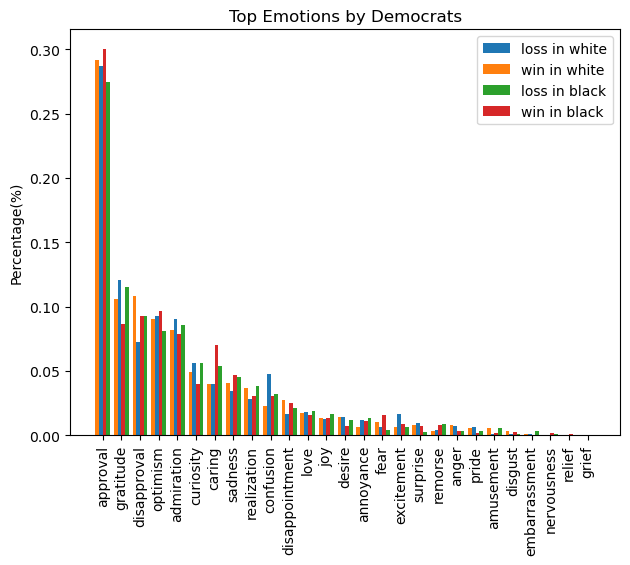

In [43]:
percentages = count_sum("democrats")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Top Emotions by Democrats')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

### Top Emotions by Republicans

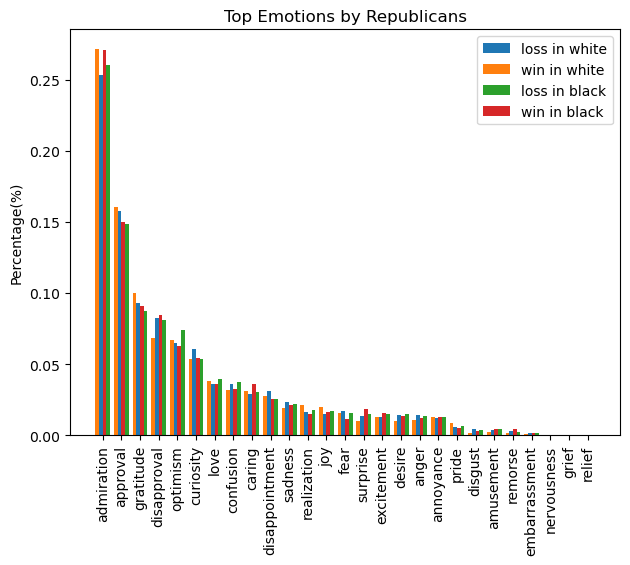

In [44]:
percentages = count_sum("republicans")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Top Emotions by Republicans')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

### Emotions that led to win in Black and loss in White states for Democrats

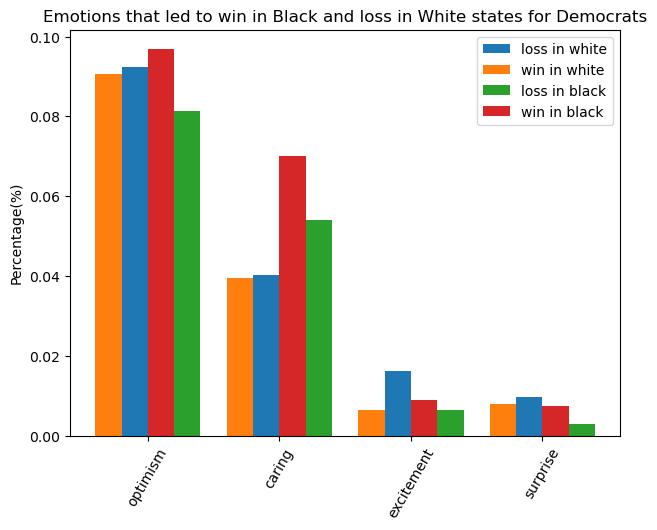

In [45]:
percentages = count_sum("democrats")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if win_in_black[i] > loss_in_black[i] and loss_in_white[i] > win_in_white[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to win in Black and loss in White states for Democrats')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Emotions that led to win in Black and loss in White states for Republicans

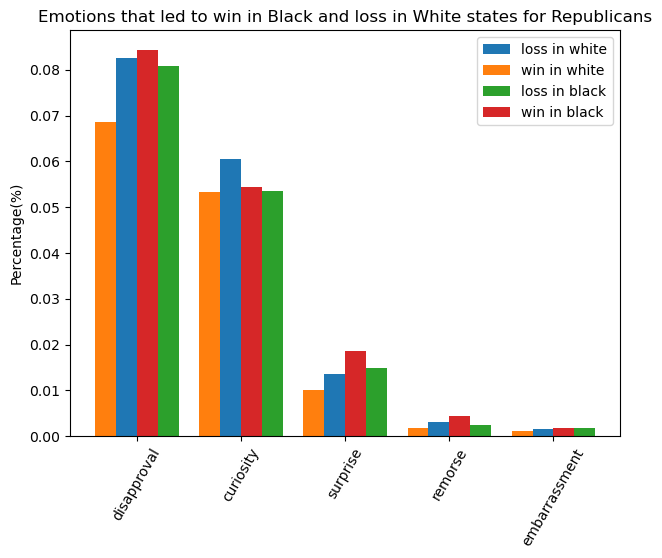

In [46]:
percentages = count_sum("republicans")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if win_in_black[i] > loss_in_black[i] and loss_in_white[i] > win_in_white[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to win in Black and loss in White states for Republicans')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Emotions that led to win in White and loss in Black states for Democrats

In [ ]:
percentages = count_sum("democrats")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if win_in_white[i] > loss_in_white[i] and loss_in_black[i] > win_in_black[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to win in White and loss in Black states for Democrats')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Emotions that led to win in White and loss in Black states for Republicans

In [ ]:
percentages = count_sum("republicans")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if win_in_white[i] > loss_in_white[i] and loss_in_black[i] > win_in_black[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to win in White and loss in Black states for Republicans')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Emotions that led to loss in both states for Democrats

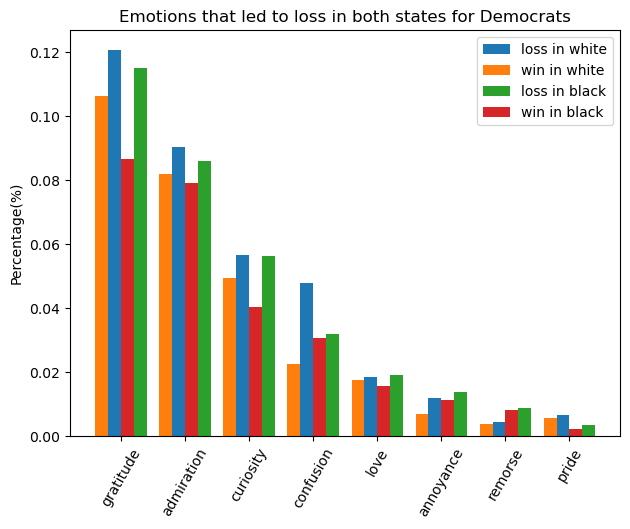

In [47]:
percentages = count_sum("democrats")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if loss_in_black[i] > win_in_black[i] and loss_in_white[i] > win_in_white[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to loss in both states for Democrats')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Emotions that led to loss in both states for Republicans

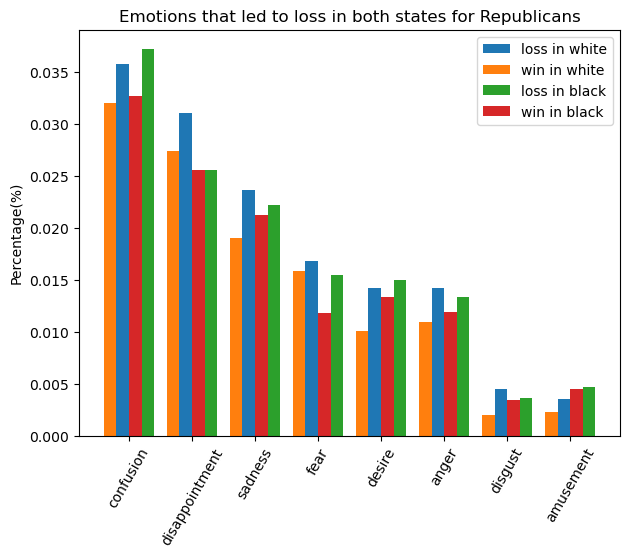

In [48]:
percentages = count_sum("republicans")
argsort_sum = np.argsort(percentages)
emotions = []
for i in range(num_labels - 1):
    emotions.append(id2label[argsort_sum[num_labels - i - 2]])

loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

temp = []
for i in range(len(emotions)):
    if loss_in_black[i] > win_in_black[i] and loss_in_white[i] > win_in_white[i]:
        temp.append(emotions[i])
emotions = temp
loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in emotions]
win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in emotions]
loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in emotions]
win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in emotions]

x = np.arange(len(emotions))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Emotions that led to loss in both states for Republicans')
ax.set_xticks(x)
ax.set_xticklabels(emotions)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=60)
plt.show()

### Net impact of sentiments(positive and negative) for Republicans and Democrats

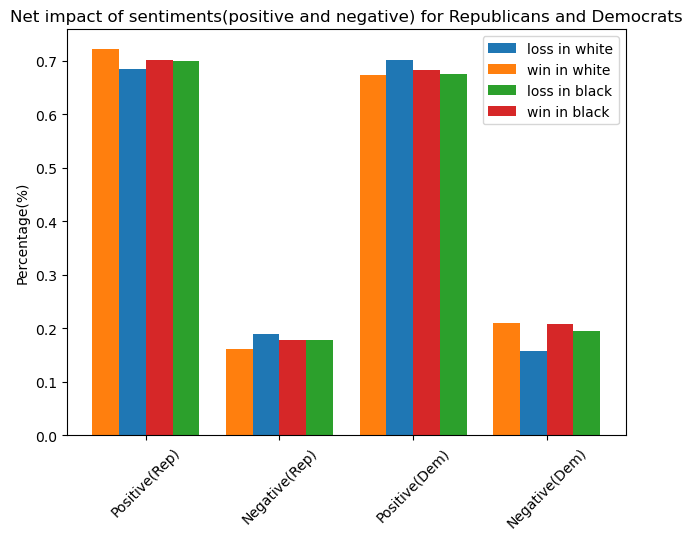

In [49]:
PositiveRep_loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in positive]
PositiveRep_win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in positive]
PositiveRep_loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in positive]
PositiveRep_win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in positive]

NegativeRep_loss_in_white = [count_in_classification("republicans", 'loss', "white")[label2id[v]] for v in negative]
NegativeRep_win_in_white = [count_in_classification("republicans", 'win', "white")[label2id[v]] for v in negative]
NegativeRep_loss_in_black = [count_in_classification("republicans", 'loss', "black")[label2id[v]] for v in negative]
NegativeRep_win_in_black = [count_in_classification("republicans", 'win', "black")[label2id[v]] for v in negative]

PositiveDem_loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in positive]
PositiveDem_win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in positive]
PositiveDem_loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in positive]
PositiveDem_win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in positive]

NegativeDem_loss_in_white = [count_in_classification("democrats", 'loss', "white")[label2id[v]] for v in negative]
NegativeDem_win_in_white = [count_in_classification("democrats", 'win', "white")[label2id[v]] for v in negative]
NegativeDem_loss_in_black = [count_in_classification("democrats", 'loss', "black")[label2id[v]] for v in negative]
NegativeDem_win_in_black = [count_in_classification("democrats", 'win', "black")[label2id[v]] for v in negative]

loss_in_white = [sum(PositiveRep_loss_in_white), sum(NegativeRep_loss_in_white), sum(PositiveDem_loss_in_white), sum(NegativeDem_loss_in_white)]
win_in_white = [sum(PositiveRep_win_in_white), sum(NegativeRep_win_in_white), sum(PositiveDem_win_in_white), sum(NegativeDem_win_in_white)]
loss_in_black = [sum(PositiveRep_loss_in_black), sum(NegativeRep_loss_in_black), sum(PositiveDem_loss_in_black), sum(NegativeDem_loss_in_black)]
win_in_black = [sum(PositiveRep_win_in_black), sum(NegativeRep_win_in_black), sum(PositiveDem_win_in_black), sum(NegativeDem_win_in_black)]

sentiments = ['Positive(Rep)', 'Negative(Rep)', 'Positive(Dem)', 'Negative(Dem)']

x = np.arange(len(sentiments))  
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width * 0.5, loss_in_white, width, label='loss in white')
rects2 = ax.bar(x - width * 1.5, win_in_white, width, label='win in white')
rects3 = ax.bar(x + width * 1.5, loss_in_black, width, label='loss in black')
rects4 = ax.bar(x + width * 0.5, win_in_black, width, label='win in black')

ax.set_ylabel('Percentage(%)')
ax.set_title('Net impact of sentiments(positive and negative) for Republicans and Democrats')
ax.set_xticks(x)
ax.set_xticklabels(sentiments)
ax.legend()

fig.tight_layout()
plt.xticks(rotation=45)
plt.show()